In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV 
import re
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,make_scorer
import xgboost as xgb

In [2]:
df_train = pd.read_csv("train.csv")
df_validation = pd.read_csv("test.csv")
# df_validation = df_validation.set_index("PassengerId")

In [3]:
df_train.drop(["PassengerId"],axis=1,inplace=True)
df_train['Number_of_relatives'] = df_train.SibSp+df_train.Parch
df_train.drop(['SibSp','Parch'],axis=1,inplace=True)

df_validation.drop(["PassengerId"],axis=1,inplace=True)
df_validation['Number_of_relatives'] = df_validation.SibSp+df_validation.Parch
df_validation.drop(['SibSp','Parch'],axis=1,inplace=True)


In [4]:
df_train.shape

(891, 10)

In [5]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Number_of_relatives
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [6]:
df_train.corr()

,Survived,Pclass,Age,Fare,Number_of_relatives
Survived,1.000000,-0.338481,-0.077221,0.257307,0.016639
Pclass,-0.338481,1.000000,-0.369226,-0.549500,0.065997
Age,-0.077221,-0.369226,1.000000,0.096067,-0.301914
Fare,0.257307,-0.549500,0.096067,1.000000,0.217138
Number_of_relatives,0.016639,0.065997,-0.301914,0.217138,1.000000


In [7]:
for sample in [df_train,df_validation]:
    sample['Sex'] = [1 if i =='male' else 0 for i in sample.Sex]

In [8]:
len(df_train[df_train['Cabin'].isna()==True])/len(df_train) 

0.7710437710437711

In [9]:
for sample in [df_train,df_validation]:
    sample['Has_cabin'] = [0 if cabin is np.NaN else 1 for cabin in sample.Cabin]
    sample.drop("Cabin",axis=1,inplace=True)

In [10]:

df_train['Embarked'].fillna('S',inplace=True)
df_validation['Embarked'].fillna('S',inplace=True)

In [11]:
le =  LabelEncoder()
df_train.Embarked = le.fit_transform(df_train.Embarked)
df_validation.Embarked = le.transform(df_validation.Embarked)

In [12]:
df_train.corr()

,Survived,Pclass,Sex,Age,Fare,Embarked,Number_of_relatives,Has_cabin
Survived,1.000000,-0.338481,-0.543351,-0.077221,0.257307,-0.167675,0.016639,0.316912
Pclass,-0.338481,1.000000,0.131900,-0.369226,-0.549500,0.162098,0.065997,-0.725541
Sex,-0.543351,0.131900,1.000000,0.093254,-0.182333,0.108262,-0.200988,-0.140391
Age,-0.077221,-0.369226,0.093254,1.000000,0.096067,-0.030394,-0.301914,0.249732
Fare,0.257307,-0.549500,-0.182333,0.096067,1.000000,-0.224719,0.217138,0.482075
Embarked,-0.167675,0.162098,0.108262,-0.030394,-0.224719,1.000000,0.066516,-0.160196
Number_of_relatives,0.016639,0.065997,-0.200988,-0.301914,0.217138,0.066516,1.000000,-0.009175
Has_cabin,0.316912,-0.725541,-0.140391,0.249732,0.482075,-0.160196,-0.009175,1.000000


In [13]:
for sample in [df_train,df_validation]:
    sample['Ticket']=  sample['Ticket'].apply(lambda x: np.int64(re.search('\d{2,}',x)[0]) if len(re.findall('\d{2,}',x))>0 else 1)
    

In [14]:
df_train.corr()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Number_of_relatives,Has_cabin
Survived,1.000000,-0.338481,-0.543351,-0.077221,-0.095605,0.257307,-0.167675,0.016639,0.316912
Pclass,-0.338481,1.000000,0.131900,-0.369226,0.284016,-0.549500,0.162098,0.065997,-0.725541
Sex,-0.543351,0.131900,1.000000,0.093254,0.075693,-0.182333,0.108262,-0.200988,-0.140391
Age,-0.077221,-0.369226,0.093254,1.000000,-0.107355,0.096067,-0.030394,-0.301914,0.249732
Ticket,-0.095605,0.284016,0.075693,-0.107355,1.000000,-0.155371,0.192306,0.015832,-0.190612
Fare,0.257307,-0.549500,-0.182333,0.096067,-0.155371,1.000000,-0.224719,0.217138,0.482075
Embarked,-0.167675,0.162098,0.108262,-0.030394,0.192306,-0.224719,1.000000,0.066516,-0.160196
Number_of_relatives,0.016639,0.065997,-0.200988,-0.301914,0.015832,0.217138,0.066516,1.000000,-0.009175
Has_cabin,0.316912,-0.725541,-0.140391,0.249732,-0.190612,0.482075,-0.160196,-0.009175,1.000000


In [15]:

for sample in [df_train,df_validation]:
    sample['title'] = sample['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


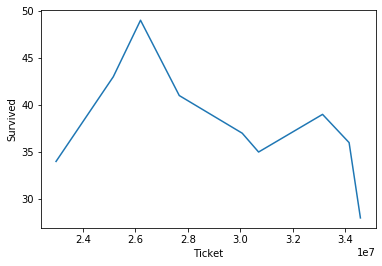

In [16]:
sns.lineplot(y=df_train.groupby(df_train.index // 100).sum().sort_values(by='Ticket')['Survived'],x=df_train.groupby(df_train.index // 100).sum().sort_values(by='Ticket')['Ticket'])

In [17]:
for sample in [df_train,df_validation]:
    sample['title'] = sample['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in [df_train,df_validation]:
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')

In [18]:
for sample in [df_train,df_validation]:
    sample['Age'] = sample['Age'].fillna(sample['Age'].mean())
    sample['Fare'] = sample['Age'].fillna(sample['Fare'].mean())

In [19]:
le_title = LabelEncoder()
df_train.title = le_title.fit_transform(df_train.title)
df_validation.title = le_title.transform(df_validation.title)

In [20]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Number_of_relatives,Has_cabin,title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,21171,22.0,2,1,0,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,17599,38.0,0,1,1,3
2,1,3,"Heikkinen, Miss. Laina",0,26.0,3101282,26.0,2,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,35.0,2,1,1,3
4,0,3,"Allen, Mr. William Henry",1,35.0,373450,35.0,2,0,0,2


In [21]:
for sample in [df_train,df_validation]:
    sample.drop("Name",axis=1,inplace=True)

In [22]:
for sample in [df_train,df_validation]:
    print(sample.isnull().any())
    print("---------")

Survived               False
Pclass                 False
Sex                    False
Age                    False
Ticket                 False
Fare                   False
Embarked               False
Number_of_relatives    False
Has_cabin              False
title                  False
dtype: bool
---------
Pclass                 False
Sex                    False
Age                    False
Ticket                 False
Fare                   False
Embarked               False
Number_of_relatives    False
Has_cabin              False
title                  False
dtype: bool
---------


In [23]:
y = df_train.Survived
X = df_train.drop("Survived",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [24]:

rnd_frst = RandomForestClassifier()
rnd_frst.fit(X_train, y_train)

pred = rnd_frst.predict(X_test)
accuracy_score(y_test, pred)

/home/daniilka/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7988826815642458

In [25]:
parametrs = {
    "learning_rate": [0.3, 0.05, 0.1, 0.4, 0.5, 0.6],
    "max_depth": [2,3,5, 6, 7],
    "n_estimators": [20, 30, 40, 50, 60, 70, 80]
}      
boost = xgb.XGBClassifier()

In [26]:
gs = GridSearchCV(boost,param_grid=parametrs,n_jobs=-1,scoring=make_scorer(accuracy_score),cv=3)
gs.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.05, 0.1, 0.4, 0.5, 0.6],
                         'max_depth': [2, 3, 5, 6, 7],
                         'n_estimators'

In [27]:

pred = gs.predict(X_test)
accuracy_score(y_test, pred)

0.7988826815642458

In [28]:
pred = gs.predict(df_validation)

In [29]:
df = pd.DataFrame(pred)

In [30]:
df.to_csv("result.csv",index=True)